In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse.linalg
import random

In [113]:
chosen_numbers = [0, 5, 6, 9]

In [114]:
data = pd.read_csv('./data.csv')

In [115]:
print(data.shape)
data.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
A = np.array(data)
X_true = A[:, 1:].T
Y_true = A[:, 0]

In [117]:
def get_chosen(X, Y, chosen_numbers = chosen_numbers):
    idx = [index for index, elem in enumerate(Y) if elem in chosen_numbers]
    X = X[:, idx]
    Y = Y[idx]
    return X, Y

In [118]:
def x_split(X, Y, N_train):
    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    X_train = X[:, train_idx]
    Y_train = Y[train_idx]

    X_test = X[:, test_idx]
    Y_test = Y[test_idx]

    return X_train, X_test, Y_train, Y_test

In [119]:
def PCA(X, k):
    c_X = np.mean(X, axis = 1)
    c_X = np.reshape(c_X, (len(c_X), 1))

    X_c = X - c_X
    U, _, _ = np.linalg.svd(X_c, full_matrices = False)

    U_k = U[:, :k]

    Z_k = U_k.T @ X

    return Z_k, U_k.T

In [120]:
def c_k(X, Y, k):
    I = (Y == k)
    tmp_X = X[:, I]
    return np.mean(tmp_X, axis = 1)

def is_pos(X):
    return np.all(np.linalg.eigvals(X) > 0)

def LDA(X, Y, k, chosen_numbers = chosen_numbers):
    cs = []
    for num in chosen_numbers:
        c = c_k(X, Y, num)
        cs.append(np.reshape(c, (len(c), 1)))
    
    glob_c = np.mean(X, axis = 1)
    glob_c = np.reshape(glob_c, (len(glob_c), 1))

    Xcs = []
    for i, _ in enumerate(cs):
        num = chosen_numbers[i]
        c = cs[i] 

        I = (Y == num)
        tmp_X = X[:, I]
        Xcs.append(tmp_X - c)
    
    X_w = np.concatenate([Xc for Xc in Xcs], axis=1)

    S_w = np.dot(X_w, X_w.T)

    gXs = []
    for c in cs:
        gXs.append(np.full(X.shape, c))
    
    gX = np.concatenate([gX for gX in gXs], axis=1)
    gX_c = gX - glob_c

    S_b = np.dot(gX_c, gX_c.T)

    L = []

    if is_pos(S_w):
        L = np.linalg.cholesky(S_w)
    else:
        tmp = S_w.copy()
        tmp += np.eye(S_w.shape[0])
        L = np.linalg.cholesky(tmp)
    
    L_inv = np.linalg.inv(L)
    simil_H = L_inv @ S_b @ L

    W = scipy.sparse.linalg.eigs(simil_H, k=k)[1]
    W = np.real(W)

    Q = L_inv.T @ W

    Z = Q.T @ X
    
    return Z, Q.T


In [121]:
def avg_centroid_dist(Z, c, three_dim=False):
    tmp = []
    c = np.array(c)
    c = np.reshape(c, (len(c), 1))
    if three_dim:
        for Z_coord in zip(Z[0, :], Z[1, :], Z[2, :]):
            Z_coord = np.array(Z_coord)
            Z_coord = np.reshape(Z_coord, (len(Z_coord), 1))
            tmp.append(np.linalg.norm((Z_coord - c))**2)
    else:
        for Z_coord in zip(Z[0, :], Z[1, :]):
            Z_coord = np.array(Z_coord)
            Z_coord = np.reshape(Z_coord, (len(Z_coord), 1))
            tmp.append(np.linalg.norm((Z_coord - c))**2)
    return np.mean(tmp)

In [122]:
def my_plot(X, Y, three_dim = False, c_dist = False, chosen_numbers = chosen_numbers, title=""):
    fig = plt.figure(figsize = (12, 12))
    ax = fig.add_subplot()
    if three_dim:
        ax = fig.add_subplot(projection="3d")
        ax.scatter(X[0, :], X[1, :], X[2, :], c=Y)
    else:
        ax.scatter(X[0, :], X[1, :], c=Y)
    for c in chosen_numbers:
        ax.scatter(*(c_k(X, Y, c)), marker = "x", color="red")
        if c_dist:
            print(f"Average distance from centroid for digit {str(c)} = {avg_centroid_dist(X, c_k(X, Y, c), three_dim = three_dim)}")
    plt.title(title)
    plt.show()

In [123]:
X, Y = get_chosen(X_true, Y_true)

In [124]:
X_train, X_test, Y_train, Y_test = x_split(X, Y, int(X.shape[1]*2/3))

In [125]:
Z_pca, P_pca = PCA(X_train, 2)
Z_lda, P_lda = LDA(X_train, Y_train, 2)

Average distance from centroid for digit 0 = 1731695.00011396
Average distance from centroid for digit 6 = 1132664.2285200525
Average distance from centroid for digit 9 = 1412517.9168470579


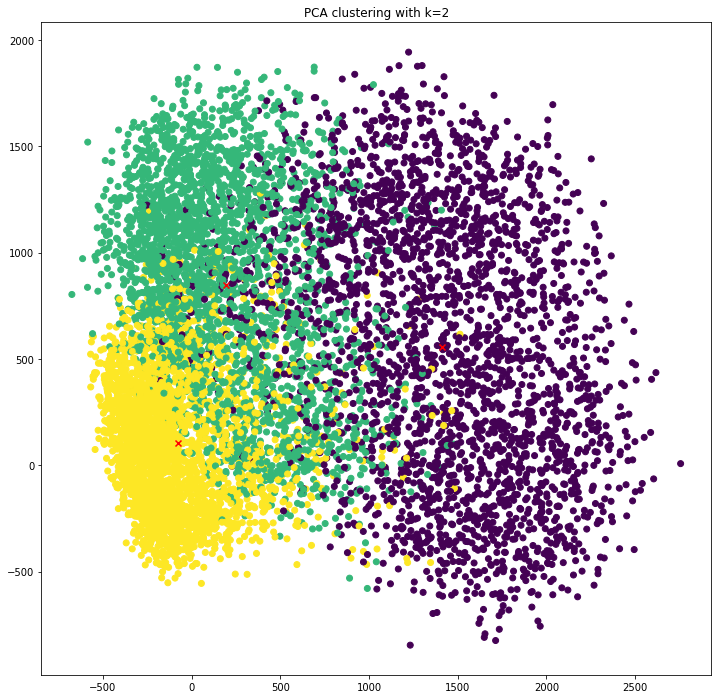

In [126]:
my_plot(Z_pca, Y_train, c_dist=True, title = "PCA clustering with k=2")

Average distance from centroid for digit 0 = 0.00414963640040924
Average distance from centroid for digit 6 = 0.004042964105827717
Average distance from centroid for digit 9 = 0.005064355623559499


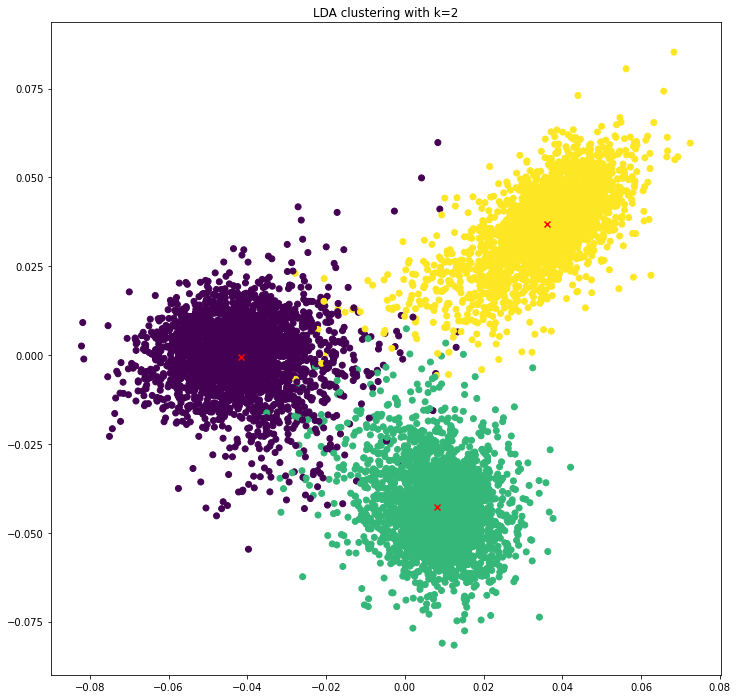

In [127]:
my_plot(Z_lda, Y_train, c_dist=True, title = "LDA clustering with k=2")

In [128]:
Z_pca_3, P_pca_3 = PCA(X_train, k=3)
Z_lda_3, P_lda_3 = LDA(X_train, Y_train, k=3)

Average distance from centroid for digit 0 = 2050960.56112035
Average distance from centroid for digit 6 = 1692379.201691076
Average distance from centroid for digit 9 = 1813497.44731675


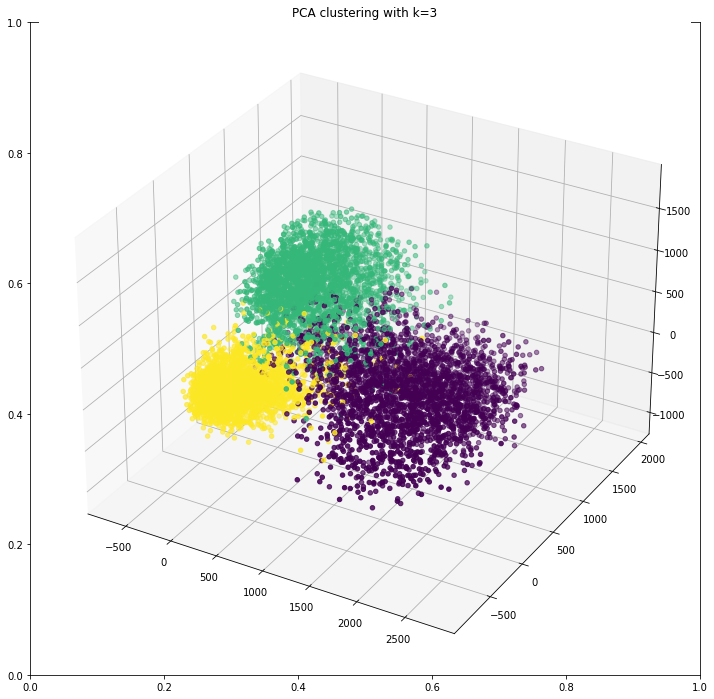

In [129]:
my_plot(Z_pca_3, Y_train, c_dist=True, three_dim = True, title = "PCA clustering with k=3")

Average distance from centroid for digit 0 = 0.004249118516638138
Average distance from centroid for digit 6 = 0.004142312858915144
Average distance from centroid for digit 9 = 0.0051637107337271435


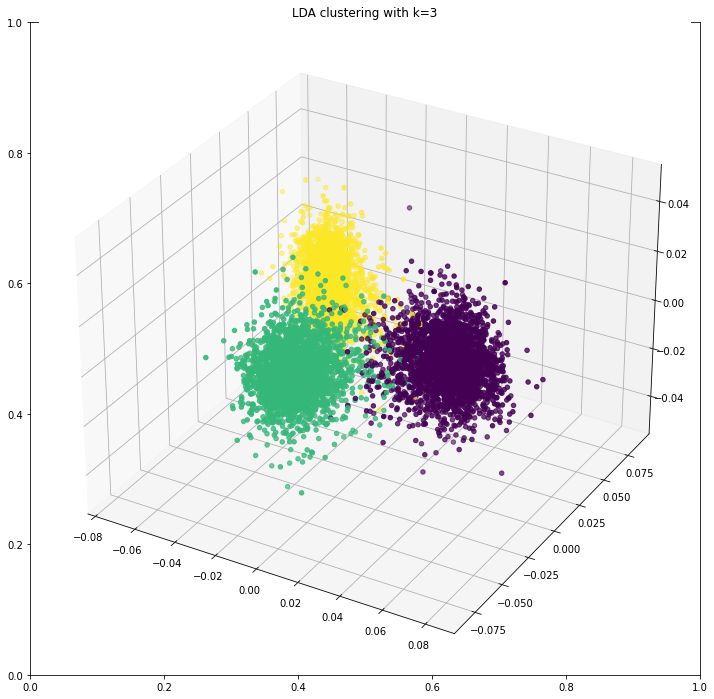

In [130]:
my_plot(Z_lda_3, Y_train, c_dist=True, three_dim = True, title = "LDA clustering with k=3")

In [131]:
def classify(Z, Y, P, x, chosen_numbers = chosen_numbers):
    z = P @ x
    cs = [c_k(Z, Y, c) for c in chosen_numbers]
    ds = [np.linalg.norm((z - c)) for c in cs]

    idx = np.argmin(ds)
    return chosen_numbers[idx]

In [132]:
hitting = {"pca": 0, "pca_3": 0, "lda": 0, "lda_3": 0}
for index, elem in enumerate(X_test.T):
    true_digit = Y_test[index]
    if classify(Z_pca, Y_train, P_pca, elem) == true_digit:
        hitting["pca"]+=1
    if classify(Z_pca_3, Y_train, P_pca_3, elem) == true_digit:
        hitting["pca_3"]+=1
    if classify(Z_lda, Y_train, P_lda, elem) == true_digit:
        hitting["lda"]+=1
    if classify(Z_lda_3, Y_train, P_lda_3, elem) == true_digit:
        hitting["lda_3"]+=1

In [133]:
accuracy = {"pca": 0, "pca_3": 0, "lda": 0, "lda_3": 0}
for idx in {"pca", "pca_3", "lda", "lda_3"}:
    accuracy[idx] = hitting[idx]/len(X_test.T)*100

In [134]:
print(f"Hitting values are = {hitting}")
print(f"Accuracy values are = {accuracy}")

Hitting values are = {'pca': 3448, 'pca_3': 3888, 'lda': 4082, 'lda_3': 4082}
Accuracy values are = {'pca': 83.0243197688418, 'pca_3': 93.61907055140863, 'lda': 98.29039248735853, 'lda_3': 98.29039248735853}
